In [81]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from wordfreq import zipf_frequency
from wordfreq import word_frequency
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
import os
# enable this line if you encounter bugs on GPU
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


np.random.seed(3314)
torch.manual_seed(3314)

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(3314)
    torch.cuda.manual_seed_all(3314)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [82]:
file = open("valid-wordle-words.txt")
words = file.read().split()
df = pd.read_excel("Problem_C_Data_Wordle(1).xlsx")
subwords = df["Word"]
avgscores = df["Average Score"]
fullscores = df[
    [
        "1 try",
        "2 tries",
        "3 tries",
        "4 tries",
        "5 tries",
        "6 tries",
        "7 or more tries (X)",
    ]
]

CZERO = ord("a")

In [83]:
wordfreq = np.asarray(
    [word_frequency(words[i], "en") for i in range(len(words))], dtype=np.float64
)
maxfreq = max(wordfreq)
wordfreq = wordfreq / maxfreq
wordfreq = 1 / (1 + np.exp(-(wordfreq - 0.5) * 3))

avgscores = np.asarray(avgscores) - min(avgscores)
avgscores = avgscores / max(avgscores)

fullscores = np.asarray(fullscores)
fullscores = fullscores.T / (np.sum(fullscores, axis=1))
fullscores = fullscores.T
fullscores=fullscores[:,2:]


charpos = np.zeros((26, 6))
for i in range(len(words)):
    for j in range(5):
        charpos[ord(words[i][j]) - CZERO][j] += wordfreq[i]
        charpos[ord(words[i][j]) - CZERO][5] += wordfreq[i]


charcombo = np.zeros((26, 26))
for i in range(len(words)):
    for j in range(4):
        a = ord(words[i][j]) - ord("a")
        b = ord(words[i][j + 1]) - ord("a")
        charcombo[a][b] += wordfreq[i]




In [84]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def getfeaturefq(word):
    # charnumber
    f0 = 0
    for j in range(5):
        same = False
        for k in range(j):
            if word[k] == word[j]:
                same = True
                break
        if not same:
            f0 += 1
    dummy = np.zeros((5))
    dummy[f0 - 1] = 1

    # charfeq
    f1 = 0
    for i in range(5):
        f1 += charpos[ord(word[i]) - ord("a")][5]
    f1 /= np.sum(charpos[:, -1])

    # charpos
    f2 = 0
    for i in range(5):
        f2 += charpos[ord(word[i]) - ord("a")][i]
    f2 /= np.sum(charpos[:, 0]) * 5

    # charcombo
    f3 = 0
    for i in range(4):
        a = ord(word[i]) - ord("a")
        b = ord(word[i + 1]) - ord("a")
        f3 += charcombo[a][b]
    f3 /= np.sum(charcombo)

    f4 = syllable_count(word)

    f5 = zipf_frequency(word, "en")
    f6 = word_frequency(word, "en")

    lo = 0
    hi = len(words) - 1
    while hi > lo:
        mid = (lo + hi) // 2
        if words[mid] < word:
            lo = mid + 1
        else:
            hi = mid
    f7 = wordfreq[lo]

    return np.concatenate((dummy, np.asarray([f1, f2, f3, f4, f5, f6, f7])), axis=0)
    # return np.asarray([f1, f2, f3, f4, f5, f6, f7])

In [85]:
class MyDataset(Dataset):

    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.unsqueeze(torch.FloatTensor(y),1)
        # self.y = torch.FloatTensor(y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [86]:
features = np.array([getfeaturefq(word) for word in subwords])
target = np.array(avgscores)

train_data = MyDataset(features[0:300], target[0:300])
test_data = MyDataset(features[300:359], target[300:359])
train_dataloader = DataLoader(dataset=train_data, batch_size=10,shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=10,shuffle=True)

In [87]:
def train_one_epoch(model, criterion, optimizer, train_dataloader, train_size):
    model.train()
    train_loss = 0.0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        batch_size = x.shape[0]

        y_pred = model(x)

        loss = criterion(y_pred, y)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

        train_loss += loss.item() * batch_size

    train_loss = train_loss / train_size
    return train_loss


def test_one_epoch(model, criterion, test_dataloader, test_size):
    # overall accuracy of the model
    correct = 0
    test_loss = 0.0
    model.eval()

    with torch.no_grad():
        for x, y in test_dataloader:
            batch_size = x.shape[0]
            x, y = x.to(device), y.to(device)

            log_prob = model(x)

            loss = criterion(log_prob, y)

            predicted = torch.argmax(log_prob, dim=1)

            test_loss += loss.item() * batch_size

            correct += (predicted == y).sum().item()
    test_loss = test_loss / test_size
    test_acc = 100 * correct / test_size
    return test_loss, test_acc

In [88]:
class NeuralNetwork(nn.Module):
    def __init__(self, xsize, ysize):
        super(NeuralNetwork, self).__init__()
        const=64
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(xsize, const),
            nn.ReLU(),
            nn.Linear(const,const),
            nn.ReLU(),
            nn.Linear(const, ysize),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork(len(features[0]), 1).to(device)

In [89]:
epochs = 1200
batch_size = 150

# Defined in Task 3.1
model = NeuralNetwork(len(features[0]), 1).to(device)

# Defined in Task 3.2
train_dataloader = DataLoader(dataset=train_data, batch_size=10,shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=10,shuffle=True)

criterion = nn.MSELoss() # we define the loss function to be NLL
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # use Adam optimizer

train_losses = []
test_losses = []

for epoch in range(1, epochs + 1): 
    # Defined in Task 3.3
    train_loss = train_one_epoch(model, criterion, optimizer, train_dataloader, len(train_data))
    test_loss, test_acc = test_one_epoch(model, criterion, test_dataloader, len(test_data))

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(
        'Epoch: [{:4d}] | * training loss : {:.3f} | o testing loss : {:.3f} | + testing acc. {:.2f} %'
        .format(epoch, train_loss, test_loss, test_acc))

Epoch: [   1] | * training loss : 0.044 | o testing loss : 0.017 | + testing acc. 0.00 %
Epoch: [   2] | * training loss : 0.022 | o testing loss : 0.016 | + testing acc. 0.00 %
Epoch: [   3] | * training loss : 0.018 | o testing loss : 0.014 | + testing acc. 0.00 %
Epoch: [   4] | * training loss : 0.018 | o testing loss : 0.014 | + testing acc. 0.00 %
Epoch: [   5] | * training loss : 0.017 | o testing loss : 0.012 | + testing acc. 0.00 %
Epoch: [   6] | * training loss : 0.017 | o testing loss : 0.012 | + testing acc. 0.00 %
Epoch: [   7] | * training loss : 0.016 | o testing loss : 0.011 | + testing acc. 0.00 %
Epoch: [   8] | * training loss : 0.016 | o testing loss : 0.011 | + testing acc. 0.00 %
Epoch: [   9] | * training loss : 0.018 | o testing loss : 0.016 | + testing acc. 0.00 %
Epoch: [  10] | * training loss : 0.016 | o testing loss : 0.011 | + testing acc. 0.00 %
Epoch: [  11] | * training loss : 0.016 | o testing loss : 0.011 | + testing acc. 0.00 %
Epoch: [  12] | * tra

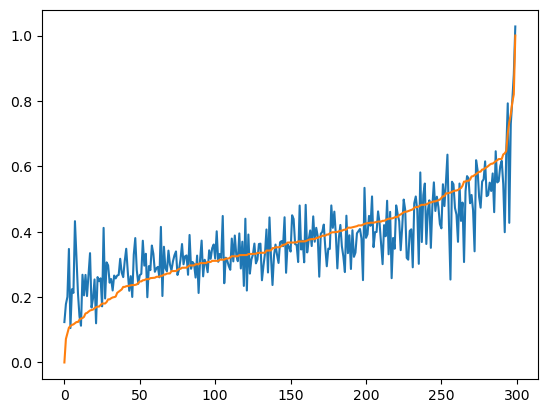

In [90]:
prescore=model(torch.FloatTensor(features))
prescore=np.asarray(torch.detach(prescore.squeeze()))

pairs=np.asarray([prescore[0:300],avgscores[0:300]]).T

pairs=np.asarray(sorted(pairs,key=lambda e:e[1])).T


plt.plot(np.arange(300),pairs[0],pairs[1])

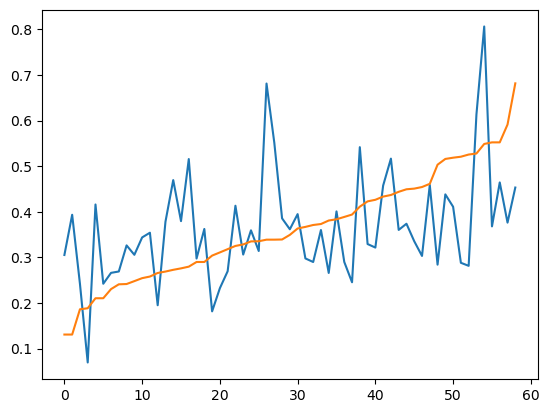

In [91]:
prescore=model(torch.FloatTensor(features))
prescore=np.asarray(torch.detach(prescore.squeeze()))

pairs=np.asarray([prescore[300:359],avgscores[300:359]]).T

pairs=np.asarray(sorted(pairs,key=lambda e:e[1])).T

plt.plot(np.arange(59),pairs[0],pairs[1])